In [1]:
from DBQuerier import DBQuerier

import os

import pandas as pd
import numpy as np
# import seaborn as sns
# sns.set(style="ticks")
import ast

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline
fft_interval = 5.13980000
from crawlab_toolbox import plotting as genplt
from scipy import signal

import datetime


In [2]:
querier = DBQuerier('db18','MMM-EMCO-E350')

In [3]:
def get_cutting_fft(startTime,endTime):
    # Create a pivot table for the controller data based on 
    # Whether this is the warmup program and the spindle speed
    query = """
        select * from 
        (select
            dateTime,
            sum(WattageS) as WattageS,
            sum(rotaryVelocityS_Commanded) as rotaryVelocityS_Commanded

        from
            (select
                db18.Controller.*,
                case when dataItemId = "WattageS" then db18.Controller.value end as WattageS,
                case when dataItemId = "rotaryVelocityS_Commanded" then db18.Controller.value end as rotaryVelocityS_Commanded

              from db18.Controller 
              where assetId = 'MMM-EMCO-E350') as t
          group by dateTime asc) as v

        where rotaryVelocityS_Commanded = 4584
        and WattageS > 1000
        and dateTime between '""" + startTime + """' and '""" + endTime + """';"""
    
    # Query database
    cursor = querier.execute_query(query)
    data = cursor.fetchall()

    # Parse data into numpy arrays based on columns
    dateTime = np.array([[data[i][0] for i in range(len(data))]]).T
    WattageS = np.array([[data[i][1] for i in range(len(data))]]).T
    rotaryVelocityS_Commanded = np.array([[data[i][2] for i in range(len(data))]]).T

    # Create pandas dataframe and save as csv
    columns = ['dateTime','WattageS','rotaryVelocityS_Commanded']
    values = np.hstack((dateTime,WattageS,rotaryVelocityS_Commanded))
    featuresDF = pd.DataFrame(data=values,columns=columns)
    featuresDF.to_csv('controller_warmup.csv')
    
    # Find ranges where we are receiving continuous data. This indicates that we are running
    # the warmup program continuously. We can use these ranges to search for vibration measurements
    featuresDF['dateTime'] = pd.to_datetime(featuresDF['dateTime'])
    featuresDF['time_diff'] = featuresDF.dateTime.diff()
    featuresDF['value_grp'] = ((featuresDF.time_diff > datetime.timedelta(seconds=1))).astype('int').cumsum()

    # Create a dataframe with the bounds on the dates and indexes
    Id_bounds_DF = pd.DataFrame({'BeginDate' : featuresDF.groupby('value_grp').dateTime.first(), 
                  'EndDate' : featuresDF.groupby('value_grp').dateTime.last(),
                         }).reset_index(drop=True)

    between_str = ''
    for i in range(Id_bounds_DF.shape[0]):
        between_str += "(FFT.dateTime between '" + str(Id_bounds_DF['BeginDate'][i]) + "' and '" + str(Id_bounds_DF['EndDate'][i])
        if i < Id_bounds_DF.shape[0] - 1:
            between_str += "') or "
        else:
            between_str += "')"
            
    query = """SELECT FFT.dateTime as dateTime,FFT.values,RMS.values as rmsVals,
    VibrationSkewness.values as skewVals,VibrationKurtosis.values as kurtVals,
    FFT.frequencyInterval,Vibration.values as vibVals FROM db18.FFT 
    inner join db18.RMS on db18.RMS.dateTime = db18.FFT.dateTime
    inner join db18.VibrationSkewness on db18.VibrationSkewness.dateTime = db18.FFT.dateTime
    inner join db18.VibrationKurtosis on db18.VibrationKurtosis.dateTime = db18.FFT.dateTime
    inner join db18.Vibration on db18.Vibration.dateTime = db18.FFT.dateTime
    where (""" + between_str + """)
    order by FFT.dateTime asc;"""
    
    cursor = querier.execute_query(query)
    data = cursor.fetchall()
    
    dateTime = np.array([[data[i][0] for i in range(len(data))]]).T
    fftVals = np.array([np.array(ast.literal_eval(data[i][1])) for i in range(len(data))])
    rmsVals = np.array([data[i][2] for i in range(len(data))])
    skewVals = np.array([data[i][3] for i in range(len(data))])
    kurtVals = np.array([data[i][4] for i in range(len(data))])
    
    frequencyInterval = [data[i][5] for i in range(len(data))]
    frequencyInterval = float(frequencyInterval[0])
    vibVals = np.array([np.array(ast.literal_eval(data[i][6])) for i in range(len(data))])
    
    
    return dateTime,fftVals,frequencyInterval,WattageS,rmsVals,skewVals,kurtVals,vibVals
        

In [4]:
nominal_dateTime,nominal_fftVals,frequencyInterval,nominal_power,nominal_rms,nominal_skew,nominal_kurt,nominal_vib = get_cutting_fft('2020-03-10 19:29:42','2020-03-10 19:32:00')

DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1' (111)

In [ ]:
anominal_dateTime,anominal_fftVals,frequencyInterval,anominal_power,anominal_rms,anominal_skew,anominal_kurt,anominal_vib = get_cutting_fft('2020-03-10 19:48:18','2020-03-10 19:51:02')

In [5]:
anominal_dateTime

NameError: name 'anominal_dateTime' is not defined

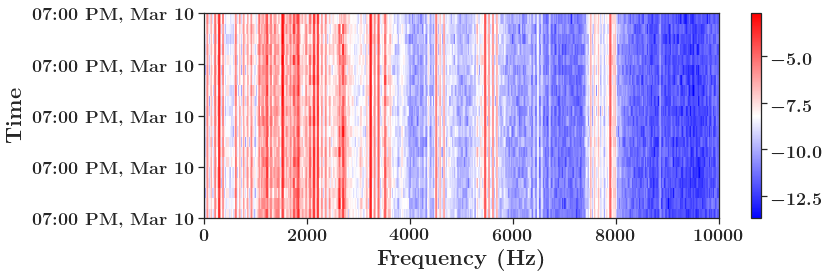

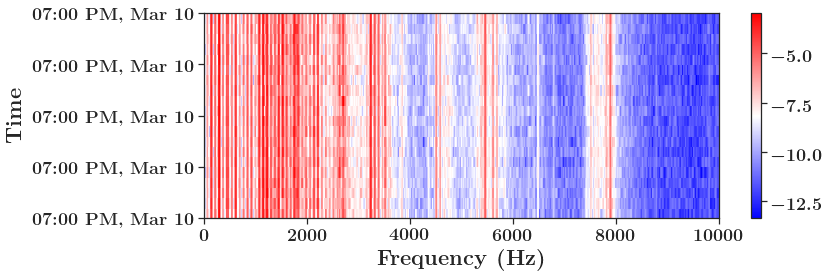

In [7]:
genplt.plot_spectrogram(nominal_dateTime.flatten().tolist(),np.log(nominal_fftVals),frequencyInterval,showplot=True)

genplt.plot_spectrogram(anominal_dateTime.flatten().tolist(),np.log(anominal_fftVals),frequencyInterval,showplot=True)

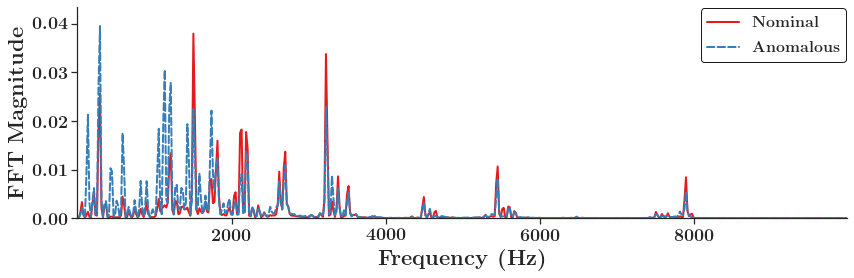

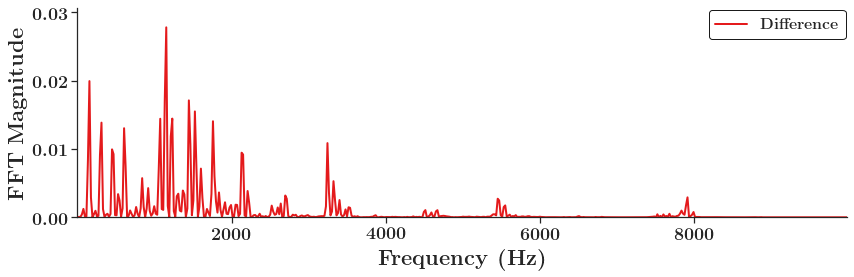

In [15]:
start = 0
end = 512

frequencies = np.arange(-0.0,10000,frequencyInterval)
# combine the responses and labels to put on our 2D plot
responses = np.vstack((np.mean(nominal_fftVals,axis=0),np.mean(anominal_fftVals,axis=0)))[:,1:]

labels = [r'Nominal','Anomalous']


# Create a 2D plot
genplt.generate_plot(frequencies[start:end], # X - coordinate on the plot
              responses[:,start:end],# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'FFT Magnitude',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous_FFT',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )

# combine the responses and labels to put on our 2D plot
responses = np.vstack((np.mean(nominal_fftVals,axis=0) - np.mean(anominal_fftVals,axis=0)))

labels = [r'Difference']


# Create a 2D plot
genplt.generate_plot(frequencies[start:end], # X - coordinate on the plot
              np.abs(responses[start:end,:]),# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'FFT Magnitude',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous_FFT_Diff',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )


In [9]:
nominal_fftVals.shape

(21, 513)

In [10]:
diff = np.abs(np.mean(nominal_fftVals,axis=0) - np.mean(anominal_fftVals,axis=0))
frequencies[np.argmax(diff)]

1152.34375

In [11]:
np.argmax(diff)

59

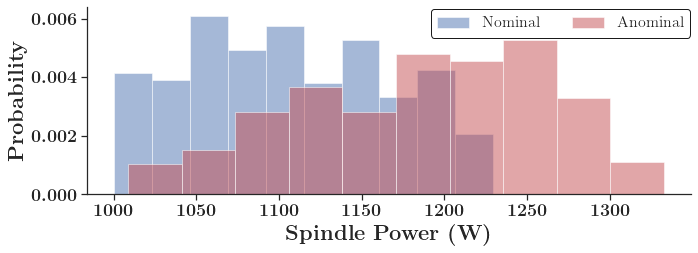

In [13]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_power, 10, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_power, 10, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
plt.savefig('Figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()


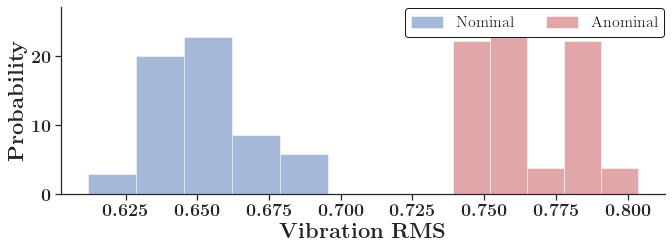

In [14]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_rms, 5, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_rms, 5, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Vibration RMS}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
plt.savefig('Figures/RMS_Anomalous_Compare.png',transparent=True)  
plt.show()


In [129]:
np.mean(nominal_fftVals,axis=1)

(21,)

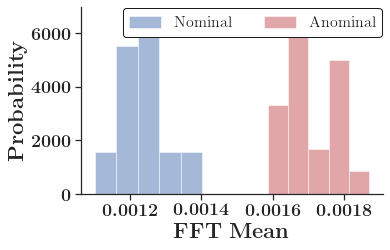

In [19]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(6,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(np.mean(nominal_fftVals,axis=1), 5, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(np.mean(anominal_fftVals,axis=1), 5, density=True, facecolor='r', alpha=0.50,label='Anominal')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{FFT Mean}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
plt.savefig('Figures/FFT_Mean_Anomalous_Compare.png',transparent=True)  
plt.show()


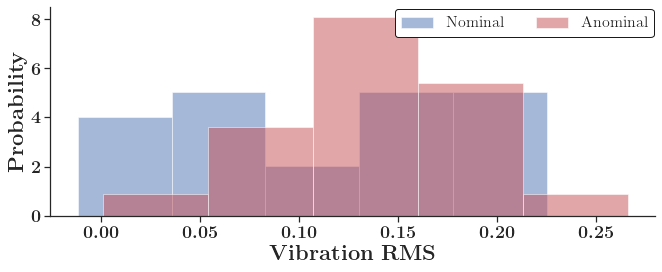

In [140]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_skew, 5, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_skew, 5, density=True, facecolor='r', alpha=0.50,label='Anominal')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Vibration Skewness}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
plt.show()


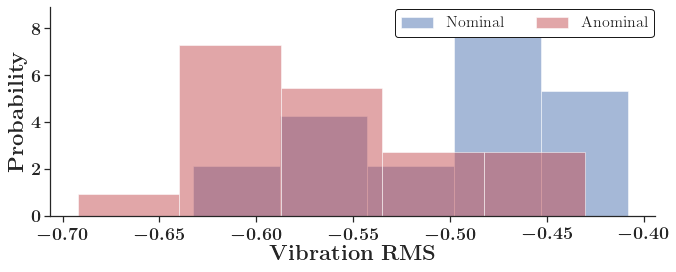

In [141]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(nominal_kurt, 5, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(anominal_kurt, 5, density=True, facecolor='r', alpha=0.50,label='Anominal')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Vibration Kurtosis}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
plt.show()


In [165]:
freqs,nominal_amps = signal.welch(nominal_vib,fs=20000,nperseg=2048)
nominal_amps = np.mean(nominal_amps,axis=0)

freqs,anominal_amps = signal.welch(anominal_vib,fs=20000,nperseg=2048)
anominal_amps = np.mean(anominal_amps,axis=0)

In [163]:
nominal_amps = np.mean(nominal_amps,axis=0)

In [15]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((nominal_amps,anominal_amps))

labels = [r'Nominal','Anominal']


# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'FFT Magnitude',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

# combine the responses and labels to put on our 2D plot
responses = np.vstack((nominal_amps,anominal_amps))

labels = [r'Nominal','Anominal']


# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'FFT Magnitude',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='publication',
              file_type='png'
             )

# combine the responses and labels to put on our 2D plot
responses = np.vstack((anominal_amps - nominal_amps))
responses = np.clip(responses,0,np.inf)
labels = [r'Nominal']


# Create a 2D plot
genplt.generate_plot(freqs, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'FFT Magnitude',   # Y - axis label
              filename='Emco_Nominal_vs_Anomalous',   # Plot filename
              folder='Figures',    # Specify the folder where the filename will be saved
              num_col=1,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=False,
                     ymin=0.05,
              transparent=False,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )

NameError: name 'nominal_amps' is not defined

In [172]:
freqs[np.argmax(anominal_amps[:50] - nominal_amps[:50])]

156.25

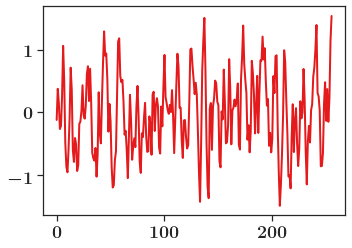

In [178]:
plt.plot(nominal_vib[0,:256])

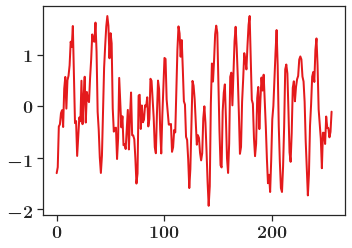

In [179]:
plt.plot(anominal_vib[0,:256])

In [10]:
a = np.arange(0,10)

In [11]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
mask = np.array([3,5])

In [19]:
np.in1d(a,mask)

array([False, False, False,  True, False,  True, False, False, False,
       False])

In [14]:
a[a!=mask]

array([0, 1, 2, 4, 5, 6, 7, 8, 9])